In [42]:
# sys
import pickle

# chroma
import chromadb
from chromadb.utils import embedding_functions
from chromadb.config import Settings

# other
import openai
import umap
import matplotlib.pyplot as plt
import numpy as np
from umap.umap_ import UMAP
import hdbscan

# inits
openai.api_key = "asdf"

In [43]:
# set up chroma, load in our data
client = chromadb.Client(Settings(
    chroma_db_impl="duckdb+parquet",
    persist_directory="./SentenceTransformers", 
))

collection = client.get_or_create_collection(name="sotu")
print(collection.count())

No embedding_function provided, using default embedding function: DefaultEmbeddingFunction https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2


42


In [44]:
# load the pickled questions
with open('./questions_st.pickle', 'rb') as f:
    questions = pickle.load(f)

print(questions)

[('ca82ba21-2eca-4b08-b2a8-07655767c11b', "\n\nWhat did Russia's Vladimir Putin do that was met with a wall of"), ('728c4d9e-f377-4fad-85f2-6f07af9a3da0', '\n\nWhat challenges are we facing as a nation that we must overcome?'), ('f23a76c5-408d-4bdb-96a1-9fb4e4583a04', ' \n\nWhat efforts did the United States take to unify the European allies'), ('c173b37a-925b-4f0a-9092-f2d918bb8dc5', ' \n\nWhat types of technology is the U.S. cutting off from'), ('f68b50ac-a6ce-4e0f-8aad-97cde9bc9937', '\n\nWhat type of assistance is the U.S. providing to Ukraine?'), ('b39ac068-e813-4745-8dc8-984b803591fc', '\n\nWhat costs have been incurred by the United States and its Allies due to'), ('c7e9d3cd-0fb1-4b86-9602-457ba60aeab2', '\n\nWhat other countries have agreed to release oil from their reserves to help reduce'), ('761109c6-b725-4797-afce-1868082ee35f', '\n\nWhat has been the response of the free world to the Russian aggression in'), ('ccd56c7f-e0eb-4c1c-9034-99d12c67bcf3', '\n\nWhat impact has the

In [45]:
# Check to see if our questions will return the corresponding paragraph in nearest neighbors 
match = []
for question in questions:
    query = collection.query(query_texts=[question[1]], n_results=3)

    if str(question[0]) in query['ids'][0]:
        match.append(1)
    else:
        match.append(0)

        print("Failed question: " + question[1].replace("\n", ""))

# count the number of matches
print("The number of matches is: " + str(sum(match)), "out of", str(len(match)) + ".")

Failed question: What challenges are we facing as a nation that we must overcome?
Failed question:  What types of technology is the U.S. cutting off from
Failed question: What costs have been incurred by the United States and its Allies due to
Failed question: What has been the response of the free world to the Russian aggression in
Failed question: What is the plan proposed by the speaker to lower costs for families?
Failed question: What measures is the Justice Department taking to ensure that the criminals who stole
Failed question: What is the PRO Act and why is it important?
Failed question:  What type of financial support is the President requesting from Congress to continue
Failed question:  What evidence is there that the burn pits could be linked to Major
The number of matches is: 33 out of 42.


/var/folders/2x/61wrqq7903g7vh405ljtcvn80000gn/T/ipykernel_62654/2631600792.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], cmap='Spectral', alpha=0.5)


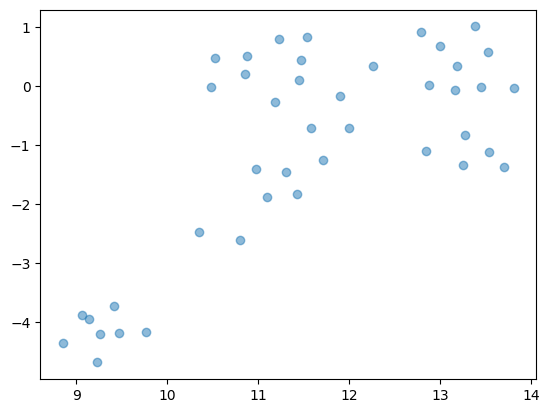

In [46]:
# get the embeddings
all_data = collection.get(include=['embeddings', 'documents'])
embeddings = all_data['embeddings']
documents = all_data['documents']

# do umap and plot directly on the embeddings
mapper = UMAP().fit(embeddings)
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], cmap='Spectral', alpha=0.5)


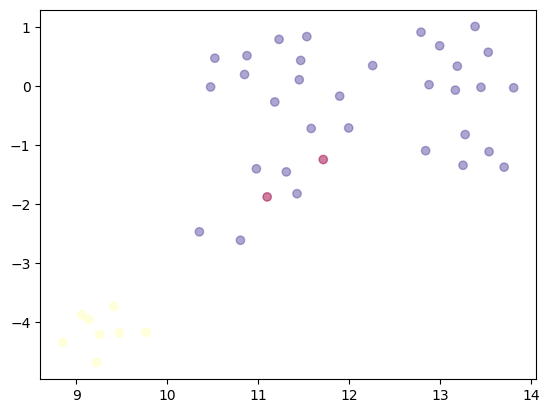

In [47]:
# cluster over the embeddings using hdbscan and plot
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1)
clusterer.fit(embeddings)
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], c=clusterer.labels_, cmap='Spectral', alpha=0.5)


In [48]:
print(clusterer.labels_)

[ 0  1  0  0  0  0  0  0  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1]


In [49]:
# use GPT3 to summarize the clusters 
labels = []

for i in range(0, max(clusterer.labels_)+1):
    cluster = np.where(clusterer.labels_ == i)[0]

    documents = []
    for index in cluster:
        documents.append(questions[index][1])

    resp = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-0301",
        messages=[{"role": "user", "content": f"Write a 3 word summary of what all the following documents are about. For Example: Russia, Putin, War.: \n\n{documents}"}],
        temperature=0.5
        
    )
    labels.append(resp.choices[0].message.content)

In [50]:
# get the average xy of each cluster
average_xy = {}

for x,y in zip(mapper.embedding_[:, 0], mapper.embedding_[:, 1]):
    # get the label of the cluster
    label = clusterer.labels_[np.where((mapper.embedding_[:, 0] == x) & (mapper.embedding_[:, 1] == y))[0][0]]

    # get the average xy of the cluster
    if label in average_xy:
        average_xy[label][0] += x
        average_xy[label][1] += y
        average_xy[label][2] += 1
    else:
        average_xy[label] = [x, y, 1]

# get the average xy of each cluster
for key in average_xy:
    average_xy[key][0] = average_xy[key][0] / average_xy[key][2]
    average_xy[key][1] = average_xy[key][1] / average_xy[key][2]


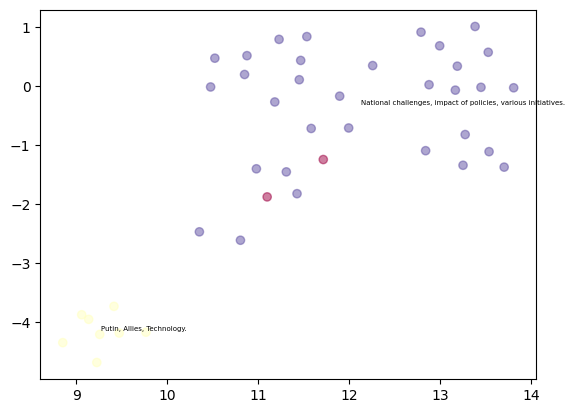

In [51]:

# plot the cluster and points
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], c=clusterer.labels_, cmap='Spectral', alpha=0.5)

# order labels by key
labels = [x for _,x in sorted(zip(average_xy.keys(), labels))]

# sample colors from cmap spectral for the labels
import matplotlib.cm as cm
colors = cm.Spectral(np.linspace(0, 1, len(labels)))

# plot the labels on the scatter plot at the average xy of each cluster in cmap='Spectral'
for key in average_xy:
    if key != -1:
        plt.annotate(labels[key], (average_xy[key][0], average_xy[key][1]), color='black', size=5)


In [52]:
# try to delete the collection and recreate it
try:
    client.delete_collection(name="sotu_questions")
except:
    pass
coll = client.get_or_create_collection(name="sotu_questions")
coll.add(documents=[question[1] for question in questions], ids=[question[0] for question in questions])

No embedding_function provided, using default embedding function: DefaultEmbeddingFunction https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2


/var/folders/2x/61wrqq7903g7vh405ljtcvn80000gn/T/ipykernel_62654/4018308013.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], c='yellow', cmap='Spectral', alpha=0.5)
/var/folders/2x/61wrqq7903g7vh405ljtcvn80000gn/T/ipykernel_62654/4018308013.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mapper.embedding_[:42, 0], mapper.embedding_[:42, 1], c='red', cmap='Spectral', alpha=0.5)


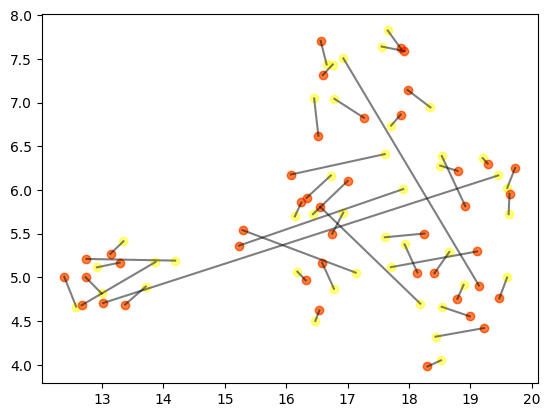

In [53]:
questions = coll.get(include=['embeddings'])
questions_embeddings = questions['embeddings']
questions_ids = questions['ids']

source_documents = collection.get(include=['embeddings'])
source_documents_embeddings = source_documents['embeddings']
source_documents_ids = source_documents['ids']

mapper = UMAP().fit(source_documents_embeddings + questions_embeddings)

# plot
plt.scatter(mapper.embedding_[:, 0], mapper.embedding_[:, 1], c='yellow', cmap='Spectral', alpha=0.5)
plt.scatter(mapper.embedding_[:42, 0], mapper.embedding_[:42, 1], c='red', cmap='Spectral', alpha=0.5)

# draw a line between matching ids in embedding_ids and embedding_ids_questions
for id in source_documents_ids:
    if id in questions_ids:
        plt.plot([
                mapper.embedding_[source_documents_ids.index(id), 0], 
                mapper.embedding_[questions_ids.index(id)+42, 0]
            ], 
            [
                mapper.embedding_[source_documents_ids.index(id), 1], 
                mapper.embedding_[questions_ids.index(id)+42, 1]
            ], c='black', alpha=0.5)

In [54]:
# find the distance between questions_embeddings and source_documents_embeddings
distances = []
for id in source_documents_ids:
    if id in questions_ids:
        distances.append(np.linalg.norm(source_documents_embeddings[0][source_documents_ids.index(id)] - questions_embeddings[0][questions_ids.index(id)]))

# find the average distance
print("The average distance between matching ids is: " + str(sum(distances)/len(distances)))

The average distance between matching ids is: 0.04192329687204966
